In [21]:
import os
import requests

import gc
import pickle
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale as preproc_scale
import plotly.express as px
%matplotlib inline
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from outlierutils import median_imputation, LabelSubmitter, plot_outlier_scores, plot_top_N, train_test_isoF

In [5]:
TRAIN_DATA_PATH = 'data/train.pkl'
TRAXCOLUMNS_PATH = 'data/trax_columns.pkl'
RAW_TRAX_DATA_PATH = 'data/train_transaction.csv'
RAW_ID_DATA_PATH = 'data/train_identity.csv'
LABEL_PATH = 'data/y_train.pkl'

### Load data

In [6]:
train = pd.read_pickle(TRAIN_DATA_PATH)
transaction_cols = pd.read_pickle(TRAXCOLUMNS_PATH) 

In [7]:
column_groups = {'card': [c for c in train.columns if c.startswith('card')],
                   'addr': [c for c in train.columns if c.startswith('addr')],
                   'dist1': ['dist1', 'dist2'],
                   'C' : [c for c in train.columns if c.startswith('C')],
                   'D' : [c for c in train.columns if c.lstrip('D').isnumeric()],
                   'M' : [c for c in train.columns if c.startswith('M')],
                   'id' : [c for c in train.columns if c.startswith('id')],   
                   'V': [c for c in train.columns if c.startswith('V')],
                   'trans': [c for c in train.columns if c.startswith('Trans')]}


### Convert V-columns

In [8]:
V_original = median_imputation(train[column_groups['V']], median_impute_limit=0)
V_original = preproc_scale(V_original)

### Do outlier detection

In [9]:
isof = train_test_isoF(X_train=V_original, 
                       y_train=train.isFraud,
                      X_test=None, 
                      y_test=None)
scores = - isof.decision_function(V_original)

AUC Score on Train: 0.746


In [11]:
scores

array([-0.19758012, -0.19675832, -0.19817832, ..., -0.19876502,
       -0.19817832, -0.19301005])

In [35]:
# Make the list with predicted positives. Take the top-1000 in outlier score
N = 1000
top_N = np.argsort(scores)[::-1][:N]

In [31]:
preds = [int(n) for n in top_N]

In [16]:
scores[top_N[:10]]

array([0.24356843, 0.24041922, 0.23884387, 0.23570322, 0.23014614,
       0.22465562, 0.22465562, 0.2238843 , 0.22318387, 0.22318387])

### Submit to API

In [51]:
ls_remote = LabelSubmitter(username='ernst', 
                           password='2718_', 
                           url="https://unsupervised-label-api.herokuapp.com/")
ls_remote.get_jwt_token()

In [52]:
response = ls_remote.post_predictions(top_N)

submitted 0 new points
number of positives in submission: 237
precision of submission: 23.70%


,N_positives_found,N_submitted,precision
admin,0.0,0.0,NaN
steffen,0.0,0.0,NaN
alessandro,0.0,0.0,NaN
theo,0.0,0.0,NaN
giulio,0.0,0.0,NaN
ernst,237.0,1000.0,23.7
test,1.0,100.0,1.0


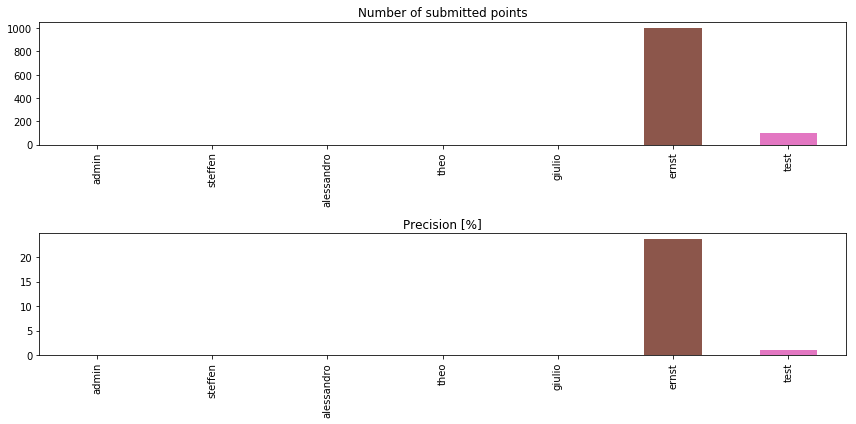

In [53]:
ls_remote.get_statistics()